In [ ]:
import pandas as pd
import numpy as np
import os
import pickle

from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
STOP_WORDS = list(ENGLISH_STOP_WORDS)

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors as mcolors, cm, lines as mlines
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

from sklearn.metrics.pairwise import cosine_similarity as cosine
from sklearn.feature_extraction.text import TfidfTransformer

from scipy.sparse import lil_matrix, csr_matrix, hstack, vstack

import networkx as nx
from sknetwork.clustering import Leiden

#!pip install google-generativeai httpx
import google.generativeai as genai
import httpx

RANDOM_STATE = 42

In [5]:
with open('gingado_us-central-bank-speeches_1996-01-01_2025-05-01.pickle', 'rb') as f:
    us_speeches = pickle.load(f)
print(type(us_speeches))

<class 'pandas.core.frame.DataFrame'>


In [11]:
#Start date: 2004-01-01 00:00:00, Break point date: 2007-05-01 00:00:00, End date: 2010-04-01 00:00:00. Found 600 speeches in the period.
temp_df = us_speeches[(us_speeches['date'] >= pd.Timestamp("2004-01-01 00:00:00")) & (us_speeches['date'] < pd.Timestamp("2010-04-01 00:00:00"))]
temp_df = temp_df.reset_index(drop=True)
temp_df.head(2)

,url,title,description,date,text,author,region,organization,documents,embeddings,sentiment,polarity
0,https://www.bis.org/review/r040115d.pdf,Ben S Bernanke: Fedspeak,"Speech by Mr Ben S Bernanke, Member of the Boa...",2004-01-03,Ben S Bernanke: Fedspeak\nSpeech by Mr Ben S B...,Ben S Bernanke,US,US Federal Reserve System,"ORGANIZATION by Mr PERSON, Member of ORGANIZAT...","[0.030032867565751076, -0.021814506500959396, ...","{'positive': 0.1293609287928451, 'negative': 0...",0.071440
1,https://www.bis.org/review/r040121e.pdf,Ben S Bernanke: Conducting monetary policy at ...,"Lecture by Mr Ben S Bernanke, Member of the Bo...",2004-01-03,Ben S Bernanke: Conducting monetary policy at ...,Ben S Bernanke,US,US Federal Reserve System,PERSON: Conducting monetary policy at very low...,"[0.004523915704339743, -0.010319530963897705, ...","{'positive': 0.07645284757018089, 'negative': ...",-0.033353


In [12]:
break_point_date = pd.to_datetime("2007-05-01 00:00:00")
period_A = temp_df[temp_df['date'] <= break_point_date].copy()
documents_A = period_A["documents"].values.tolist()
embeddings_A = np.stack(period_A['embeddings'].values)

period_B = temp_df[temp_df['date'] > break_point_date].copy()
documents_B = period_B["documents"].values.tolist()
embeddings_B = np.stack(period_B['embeddings'].values)

embeddings_A.shape, embeddings_B.shape

((333, 1536), (267, 1536))

In [13]:
DIM_SIZE = 100
N_NEIGHBORS = 200
MIN_DIST = 0.0

# Dimensionality reduction used for clustering
dim_reducer = UMAP(n_components=DIM_SIZE, n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST, 
                   metric='cosine', transform_mode="embedding", random_state=RANDOM_STATE)

# Dimensionality reduction used only for visualization purposes
vizualier = UMAP(n_components=2, n_neighbors=N_NEIGHBORS, min_dist=MIN_DIST, 
                   metric='cosine', transform_mode="embedding", random_state=RANDOM_STATE)

In [14]:
reduced_embeddings_A = dim_reducer.fit_transform(embeddings_A)
print(reduced_embeddings_A.shape)

graph_A = dim_reducer.graph_
print(graph_A.shape)

/opt/anaconda3/envs/py_3_13_2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py_3_13_2/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(333, 100)
(333, 333)


In [15]:
reduced_embeddings_B = dim_reducer.transform(embeddings_B)
print(reduced_embeddings_B.shape)

graph_B = umap.umap_.fuzzy_simplicial_set(
    X=embeddings_B,
    n_neighbors=dim_reducer.n_neighbors,
    random_state=dim_reducer.random_state,
    metric=dim_reducer.metric,
    metric_kwds=dim_reducer._metric_kwds,
    knn_indices=None,
    knn_dists=None,
    angular=dim_reducer.angular_rp_forest,
    set_op_mix_ratio=dim_reducer.set_op_mix_ratio,
    local_connectivity=dim_reducer.local_connectivity,
    verbose=False
)[0]
print(graph_B.shape)

/opt/anaconda3/envs/py_3_13_2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(267, 100)
(267, 267)


In [51]:
sim_matrix = cosine(embeddings_B, embeddings_A)
# sim_matrix[sim_matrix < 0.75] = 0  

n_B, n_A = sim_matrix.shape
k = 10
cross_edges = lil_matrix((n_B, n_A))
for i in range(n_B):
    top_k_indices = np.argpartition(sim_matrix[i], -k)[-k:]
    cross_edges[i, top_k_indices] = sim_matrix[i, top_k_indices]
cross_edges = csr_matrix(cross_edges)

top = hstack([graph_A, cross_edges.T])
bottom = hstack([cross_edges, graph_B])
graph = vstack([top, bottom])

In [29]:
embeddings_A_2D = vizualier.fit_transform(embeddings_A)
period_A["2D_embeddings"] = list(embeddings_A_2D)
embeddings_B_2D = vizualier.transform(embeddings_B)
period_B["2D_embeddings"] = list(embeddings_B_2D)

/opt/anaconda3/envs/py_3_13_2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/py_3_13_2/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/py_3_13_2/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
dense_graph = graph.todense()
nx_graph = nx.from_numpy_array(np.array(dense_graph))

In [37]:
RESOLUTION = 2.0
MODULARITY = "dugue"
clusterer = Leiden(resolution=RESOLUTION, modularity=MODULARITY, random_state=RANDOM_STATE)

adjacency_matrix = csr_matrix(graph)
print(adjacency_matrix.shape)
labels = clusterer.fit_predict(adjacency_matrix)
probs = clusterer.predict_proba()

period_A["cluster"] = labels[:len(embeddings_A)]
period_A["cluster_probs"] = probs[:len(embeddings_A)].tolist()
period_B["cluster"] = labels[len(embeddings_A):]
period_B["cluster_probs"] = probs[len(embeddings_A):].tolist()
print(f"Found {len(np.unique(labels, return_counts=False))} clusters.")

(600, 600)
Found 15 clusters.


In [ ]:
cluster_info_A = pd.DataFrame({"Cluster": np.unique(labels[:len(embeddings_A)])})
cluster_info_A["Count"] = cluster_info_A["Cluster"].map(period_A["cluster"].value_counts())
cluster_info_A["Top_Words"] = cluster_info_A["Cluster"].apply(
    lambda x: get_top_n_words(period_A[period_A["cluster"] == x]["documents"].values.tolist(), n=10)
)
cluster_info_A["Polarity"] = cluster_info_A["Cluster"].apply(lambda x: period_A[period_A["cluster"] == x]["polarity"].mean())
cluster_info_A["Centroid"] = cluster_info_A["Cluster"].apply(
    lambda x: np.mean(period_A[period_A["cluster"] == x]['embeddings'], axis=0)
)
cluster_info_A["2D_Centroid"] = cluster_info_A["Cluster"].apply(
    lambda x: np.mean(period_A[period_A["cluster"] == x]['2D_embeddings'], axis=0)
)
cluster_info_A["Top_Representative_Docs"] = cluster_info_A[["Cluster", "Centroid"]].apply(
    lambda x:
        get_top_n_representative_documents(
            period_A[period_A["cluster"] == x["Cluster"]]["documents"].values.tolist(),
            np.stack(period_A[period_A["cluster"] == x["Cluster"]]['embeddings'].values), 
            x["Centroid"],
            n=10
        ),
        axis=1
)

cluster_info_B = pd.DataFrame({"Cluster": np.unique(labels[len(embeddings_A):])})
cluster_info_B["Count"] = cluster_info_B["Cluster"].map(period_B["cluster"].value_counts())
cluster_info_B["Top_Words"] = cluster_info_B["Cluster"].apply(
    lambda x: get_top_n_words(period_B[period_B["cluster"] == x]["documents"].values.tolist(), n=10)
)
cluster_info_B["Polarity"] = cluster_info_B["Cluster"].apply(lambda x: period_B[period_B["cluster"] == x]["polarity"].mean())
cluster_info_B["Centroid"] = cluster_info_B["Cluster"].apply(
    lambda x: np.mean(period_B[period_B["cluster"] == x]['embeddings'], axis=0)
)
cluster_info_B["2D_Centroid"] = cluster_info_B["Cluster"].apply(
    lambda x: np.mean(period_B[period_B["cluster"] == x]['2D_embeddings'], axis=0)
)
cluster_info_B["Top_Representative_Docs"] = cluster_info_B[["Cluster", "Centroid"]].apply(
    lambda x:
        get_top_n_representative_documents(
            period_B[period_B["cluster"] == x["Cluster"]]["documents"].values.tolist(),
            np.stack(period_B[period_B["cluster"] == x["Cluster"]]['embeddings'].values), 
            x["Centroid"],
            n=10
        ),
        axis=1
)


if compute_MMR:
    cluster_info_A["MMR"] = cluster_info_A[["Top_Words", "Top_Representative_Docs"]].apply(
        lambda x: get_mmr_representation(x["Top_Words"], x["Top_Representative_Docs"],
                                        diversity=0.7, top_n=10, model_name="ProsusAI/finbert"),
        axis=1
    )
    cluster_info_B["MMR"] = cluster_info_B[["Top_Words", "Top_Representative_Docs"]].apply(
        lambda x: get_mmr_representation(x["Top_Words"], x["Top_Representative_Docs"],
                                        diversity=0.7, top_n=10, model_name="ProsusAI/finbert"),
        axis=1
    )

In [58]:
# compute centroid drifts
get_x = lambda x: np.nan if not isinstance(x, (list, tuple, np.ndarray)) or len(x) < 1 else x[0]
get_y = lambda x: np.nan if not isinstance(x, (list, tuple, np.ndarray)) or len(x) < 2 else x[1]

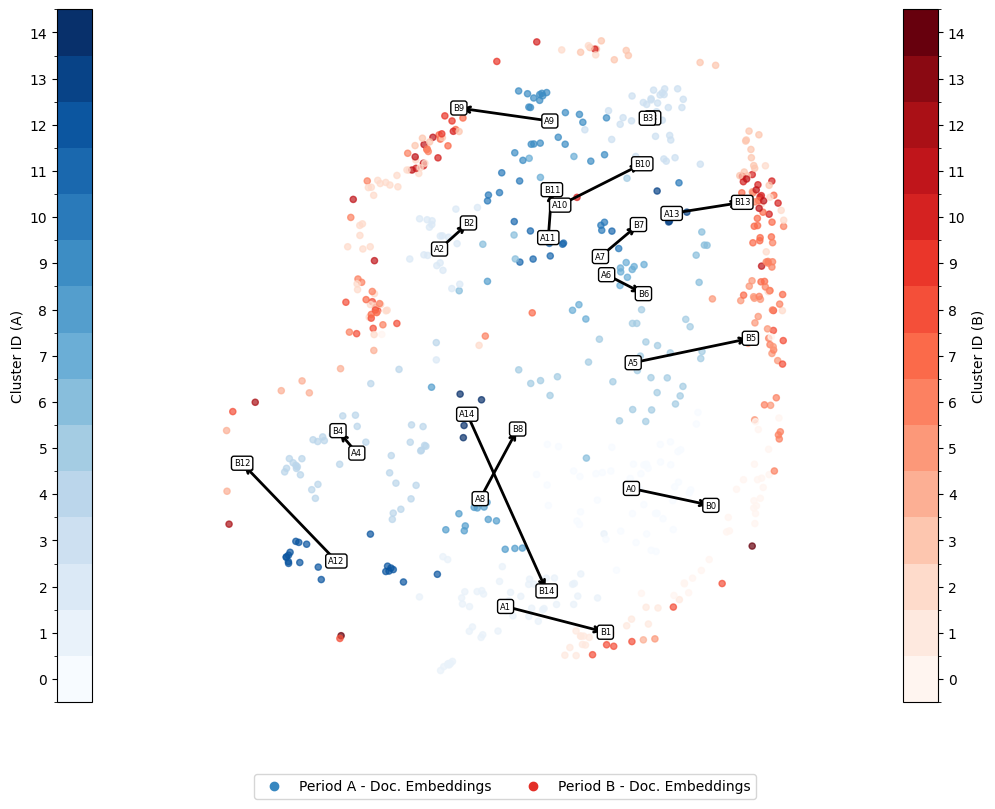

In [59]:
# view umap, clusters and centroid drifts


fig, ax = plt.subplots(figsize=(10, 8), layout="constrained")
nb_clusters_A = len(cluster_info_A["Cluster"])
nb_clusters_B = len(cluster_info_B["Cluster"])
a_color = mpl.colormaps['Blues'].resampled(nb_clusters_A) #cm.get_cmap('Blues', nb_clusters_A)
b_color = mpl.colormaps['Reds'].resampled(nb_clusters_B) #cm.get_cmap('Reds', nb_clusters_B)
norm_A = mcolors.BoundaryNorm(boundaries=np.arange(nb_clusters_A + 1) - 0.5, ncolors=nb_clusters_A)
norm_B = mcolors.BoundaryNorm(boundaries=np.arange(nb_clusters_B + 1) - 0.5, ncolors=nb_clusters_B)

scatter_A = ax.scatter(
    period_A["2D_embeddings"].apply(get_x),
    period_A["2D_embeddings"].apply(get_y),
    c=period_A["cluster"],
    cmap=a_color,
    s=20,
    label="Period A - Doc. Embeddings",
    alpha=0.7
)

scatter_B = ax.scatter(
    period_B["2D_embeddings"].apply(get_x),
    period_B["2D_embeddings"].apply(get_y),
    c=period_B["cluster"],
    cmap=b_color,
    s=20,
    label="Period B - Doc. Embeddings",
    alpha=0.7
)

# --- Plot drift arrows ---
compute_on = "2D_Centroid"
drifts = {}
for idx, row in cluster_info_B.iterrows():
    cluster_id = row['Cluster']
    if cluster_id in cluster_info_A['Cluster'].values:
        centroid_A_2D = cluster_info_A[cluster_info_A['Cluster'] == cluster_id]["2D_Centroid"].values[0]
        centroid_B_2D = row["2D_Centroid"]

        start_x, start_y = get_x(centroid_A_2D), get_y(centroid_A_2D)
        end_x, end_y = get_x(centroid_B_2D), get_y(centroid_B_2D)

        ax.annotate(
            "",
            xy=(end_x, end_y),
            xytext=(start_x, start_y),
            arrowprops=dict(arrowstyle="->", color="black", lw=2),
        )

        drifts[cluster_id] = np.array(centroid_B_2D) - np.array(centroid_A_2D)
    else:
        drifts[cluster_id] = np.nan

# --- Add text labels for clusters ---
for idx, row in cluster_info_A.iterrows():
    cluster_id = row['Cluster']
    centroid_A_2D = cluster_info_A[cluster_info_A['Cluster'] == cluster_id]["2D_Centroid"].values[0]
    centroid_B_2D = cluster_info_B[cluster_info_B['Cluster'] == cluster_id]["2D_Centroid"].values[0]
    start_x, start_y = get_x(centroid_A_2D), get_y(centroid_A_2D)
    end_x, end_y = get_x(centroid_B_2D), get_y(centroid_B_2D)
    ax.text(
        start_x, start_y, # Start point
        # (start_x + end_x) / 2, (start_y + end_y) / 2, # Middle point
        # end_x, end_y, # End point
        f"A{cluster_id}", fontsize=6, ha="center", va="center", color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )
    ax.text(
        # start_x, start_y, # Start point
        # (start_x + end_x) / 2, (start_y + end_y) / 2, # Middle point
        end_x, end_y, # End point
        f"B{cluster_id}", fontsize=6, ha="center", va="center", color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
    )

# --- Add color bar ---
cbar_A = fig.colorbar(
    ScalarMappable(norm=norm_A, cmap=a_color), ax=ax, orientation="vertical", location="left", pad=0.15, ticks=np.arange(nb_clusters_A)
)
cbar_A.set_label("Cluster ID (A)", fontsize=10)
cbar_B = fig.colorbar(
    ScalarMappable(norm=norm_B, cmap=b_color), ax=ax, orientation="vertical", location="right", pad=0.15, ticks=np.arange(nb_clusters_B)
)
cbar_B.set_label("Cluster ID (B)", fontsize=10)

# --- Final styling ---
legend_dot_A = mlines.Line2D([], [], color='#3787c0', marker='o', linestyle='None', markersize=6, label='Period A - Doc. Embeddings')
legend_dot_B = mlines.Line2D([], [], color='#e32f27', marker='o', linestyle='None', markersize=6, label='Period B - Doc. Embeddings')
ax.legend(handles=[legend_dot_A, legend_dot_B], loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=2)
ax.set_xticks([]); ax.set_yticks([])
ax.set_frame_on(False)
# plt.tight_layout()

# ax.set_rasterized(True)
#plt.savefig("images/topic_embedding_drift_speeches_plot.pdf", format="pdf", bbox_inches='tight')
# plt.close(fig)

plt.show()

In [74]:
cluster_info_A.head(2)

,Cluster,Count,Top_Words,Polarity,Centroid,2D_Centroid,Top_Representative_Docs,Top_Words_TFIDF
0,0,48,"{'inflation': 2089, 'date': 2087, 'organizatio...",-0.032578,"[0.009283881518058479, 0.0003800959457294084, ...","[9.154539744059244, -1.2773158550262451]","[Remarks by Mr PERSON, PERSON, Vice Chairman o...","{'inflation': 0.4641199458197222, 'date': 0.35..."
1,1,48,"{'date': 3066, 'num': 1558, 'prices': 1076, 'o...",-0.026576,"[0.015081272521759578, 0.018581748350698035, 0...","[8.169541676839193, -2.5851213137308755]","[Remarks by Mr PERSON, Member of ORGANIZATION ...","{'date': 0.5890872033112446, 'num': 0.28042809..."


In [158]:
narrative_dimensions = [
    "Economic growth – Economic decline",
    "Financial stability – Financial instability",
    "Innovation – Tradition",
    "Market confidence – Market anxiety",
    "Risk-taking – Risk aversion",
    "Technological optimism – Technological skepticism",
    "Environmental responsibility – Environmental negligence",
    "Public health focus – Economic focus",
    "Consumer empowerment – Consumer manipulation",
    "Globalization – Nationalism",
    "Regulation – Deregulation",
    "Competition – Monopoly",
    "Efficiency – Redundancy",
    "Productivity – Laziness",
    "Sustainability – Exploitation",
    "Scalability – Inflexibility",
    "Inclusivity – Exclusivity",
    "Transparency – Obfuscation",
    "Accountability – Irresponsibility",
    "Safety – Danger",
    "Collaboration – Isolation",
    "Accessibility – Elitism",
    "Long-term thinking – Short-term thinking",
    "Innovation – Stagnation",
    
    # Moral & Ethical
    "Justice – Injustice",
    "Equity – Inequity",
    "Honesty – Deception",
    "Integrity – Corruption",
    "Altruism – Self-interest",
    "Responsibility – Negligence",
    "Loyalty – Betrayal",
    "Consent – Coercion",
    "Fairness – Bias",
    "Empathy – Apathy",
    "Gratitude – Entitlement",
    "Generosity – Greed",
    "Respect – Disregard",
    "Forgiveness – Vengeance",
    "Courage – Cowardice",
    "Authenticity – Hypocrisy",
    
    # Social & Interpersonal
    "Authority – Rebellion",
    "Agreement – Disagreement",
    "Politeness – Rudeness",
    "Assertiveness – Passivity",
    "Consensus – Polarization",
    "Trust – Distrust",
    "Leadership – Subordination",
    "Support – Opposition",
    "Closeness – Distance",
    "Mentorship – Criticism",
    "Professionalism – Informality",
    "Respect – Dismissiveness",
    
    # Emotional & Psychological
    "Optimism – Pessimism",
    "Excitement – Boredom",
    "Confidence – Doubt",
    "Calm – Anxiety",
    "Hope – Despair",
    "Happiness – Sadness",
    "Empowerment – Helplessness",
    "Passion – Indifference",
    "Resilience – Fragility",
    "Fulfillment – Frustration",
    "Enthusiasm – Apathy",
    "Pride – Shame",
    "Joy – Grief",
    "Motivation – Complacency",
    "Curiosity – Disinterest",
    "Satisfaction – Disappointment",
    
    # Tone & Style
    "Formal – Informal",
    "Objective – Subjective",
    "Concise – Wordy",
    "Direct – Indirect",
    "Sincere – Sarcastic",
    "Serious – Humorous",
    "Persuasive – Descriptive",
    "Analytical – Narrative",
    "Technical – Layperson-friendly",
    "Measured – Exaggerated",
    "Assertive – Tentative",
    "Friendly – Hostile",
    
    # Intent & Function
    "Persuasion – Information",
    "Promotion – Critique",
    "Instruction – Storytelling",
    "Reporting – Speculating",
    "Defending – Attacking",
    "Clarification – Confusion",
    "Invitation – Rejection",
    "Compliance – Resistance",
    "Escalation – De-escalation",
    "Problem framing – Solution framing",
    "Root cause analysis – Symptom description",
    "Innovation proposal – Status quo defense",
    "Apology – Justification",
    "Advocacy – Observation",
    
    # Perspective & Framing
    "First-person – Third-person",
    "Subjective – Objective",
    "Quantitative – Qualitative",
    "Macro – Micro",
    "Local – Global",
    "Personal – Institutional",
    "Insider – Outsider",
    "Predictive – Retrospective",
    "Static – Dynamic",
    "Present-focused – Future-focused",
    
    # Academic & Scientific Style
    "Evidence-based – Anecdotal",
    "Theoretical – Empirical",
    "Precise – Ambiguous",
    "Cautious – Bold",
    "Methodological – Exploratory",
    "Hypothesis-driven – Observation-driven",
    "Peer-oriented – Public-oriented",
    "Originality – Replication",
    "Novelty – Confirmation",
    "Scientific neutrality – Advocacy",
    
    # Consumer & Review
    "Value for money – Overpriced",
    "User-friendly – Complicated",
    "High quality – Poor quality",
    "Responsive – Unresponsive",
    "Durable – Fragile",
    "Reliable – Buggy",
    "Trustworthy – Misleading",
    "Helpful – Unhelpful",
    "Recommended – Not recommended"
]
dimension_list_str = "\n".join(narrative_dimensions)
with open("out/narrative_dimensions.txt", "w", encoding="utf-8") as f:
    f.write(dimension_list_str)

In [160]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt_template = f"""
Role: You are a narrative analyst specialist in identifying all semantic perspectives in texts, so called narrative dimensions.
Task: Identify and compare all narrative dimensions present in the texts "text1" and "text2".

Narrative dimensions are fine-grained semantic elements that capture contrasts in topic, subtopic, perspective, intention, nuance, morality, emotion, sentiment, personality, intensity, solution/problem framing, accountability, or other discourse-level distinctions.
Use the list of dimensions below as inspiration, allow the emergence of any new one, be creative and open. Only output JSON as specified.

--- Dimensions ---
{dimension_list_str}

For each narrative dimension, follow this output format:
- Title: A short phrase that captures the main contrast.
- Subtitle: The two poles of the dimension (e.g., financial stability – financial instability).
- Presence: Indicate whether it appears in text1 only, text2 only, or both.
- Coverage: Percentage (0–100%) indicating how much of each text is devoted to this dimension. Together, the dimensions should account for 100% of each text. Zero coverage is allowed for one text, but not both.
- Perspective Shift: Estimate the directional change between texts as a percentage (0–100%).
- Cosine Similarity: Indicate the cosine similarity (from –1 to 1) between the text representations for this dimension.
- Evidence: Quote at least 2–3 representative sentences from each text that reflect each pole.

Example Output Format:

Dimension: Financial stability  
Subtitle: Stability – Instability  
Presence: Both  
Coverage: text1: 30%, text2: 15%  
Perspective Shift: 40%  
Cosine Similarity: –0.42  
Evidence:  
- text1: 
  • "The company faces major risks due to market downturn."  
  • "Investors are pulling out amid uncertainty."  
  • "Revenue has dropped by 20% over the last quarter."  
- text2: 
  • "Recent investments have secured long-term growth."  
  • "The financial outlook remains positive, according to the Q2 report."  
  • "Diversification strategies have reduced exposure to risk."

Repeat this for all narrative dimensions needed to fully account for both texts.

Output **only** a valid JSON list of objects in this exact format — no additional text, no commentary, no explanations.

Example output:
[
  {{
    "dimension_title": "Financial Stability",
    "polar_extremes_subtitle": "Financial instability – Financial stability",
    "presence": "both",
    "coverage_text1": 60,
    "coverage_text2": 40,
    "difference_confidence": 40,
    "cosine_similarity": 0.72,
    "text1_evidence_sentences": [
      "The company is struggling with cash flow.",
      "Debt levels are increasing rapidly.",
      "Investors have lost confidence."
    ],
    "text2_evidence_sentences": [
      "Strong profit growth is reported.",
      "Revenue streams are diversifying.",
      "The market shows consistent recovery."
    ]
  }}
]

--- Begin Text Analysis ---

text1:
{text1}

text2:
{text2}
"""
    return prompt_template


In [ ]:
import google.generativeai as genai
import io
import httpx
import os
from dotenv import load_dotenv

#load_dotenv() # Load the .env file with API key
#genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

#genai.configure(api_key="YOUE_API_KEY_H")
client = genai.GenerativeModel("gemini-2.0-flash") 

```json
[
  {
    "dimension_title": "Market Flexibility",
    "polar_extremes_subtitle": "Rigidity – Flexibility",
    "presence": "both",
    "coverage_text1": 70,
    "coverage_text2": 60,
    "difference_confidence": 15,
    "cosine_similarity": 0.85,
    "text1_evidence_sentences": [
      "Today I should like to reflect on some of the ways in which economic policy both affects and is affected by the increasing flexibility of the U.S. economy.",
      "Assisting in the dismantling of economic restraints was the persistent, PERSON, lowering of barriers to cross-border trade and finance.",
      "Deregulation and the newer information technologies have joined, in the United States and elsewhere, to advance flexibility in the financial sector."
    ],
    "text2_evidence_sentences": [
      "Ultimately the ability of the economy to withstand shocks is a function of the flexibility and resiliency of labor, product, and capital markets; strong and resilient market infrastructures; and 

In [146]:
import json
import re
import ast
import os

def safe_json_load(raw_response_text):
    # Strip leading/trailing whitespace and remove non-JSON "explanation" text if any
    raw_text = raw_response_text.strip()

    # Attempt quick fix: if it starts/ends with JSON brackets
    if not raw_text.startswith('[') and '[' in raw_text:
        raw_text = raw_text[raw_text.index('['):]
    if not raw_text.endswith(']') and ']' in raw_text:
        raw_text = raw_text[:raw_text.rindex(']') + 1]

    # Remove or escape invalid escape characters
    def escape_invalid_escapes(s):
        # Fix invalid escape sequences: \x, \u (if malformed), or backslashes not part of valid escape
        s = re.sub(r'\\(?!["\\/bfnrtu])', r'\\\\', s)  # Replace lone backslashes
        return s

    try:
        return json.loads(escape_invalid_escapes(raw_text))
    except json.JSONDecodeError as e:
        try:
            # Try ast.literal_eval as fallback (tolerates single quotes, trailing commas)
            return ast.literal_eval(raw_text)
        except Exception as fallback_error:
            print("⚠️ JSON parsing failed.")
            print("JSON error:", e)
            print("Fallback error:", fallback_error)
            return None


In [ ]:
for i in range(len(cluster_info_A)):
    text1 = cluster_info_A['Top_Representative_Docs'].iloc[i]
    text2 = cluster_info_B['Top_Representative_Docs'].iloc[i]

    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = client.generate_content(prompt)

    # Dynamic response variable (you can also use a list or dict instead of naming each one)
    var_name = f"response_row{i}"
    globals()[var_name] = response

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response.text)

    # Save to file
    with open(f"out/macro_ND_row{i}.json", "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

    print(f"✅ Processed and saved row {i}")